In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
import random
import sys

from salvus.mesh.models_1D import model 
from salvus.mesh.tools.transforms import uniformly_refine

from classes.poisson import poisson_solver
from classes.gmtplot_class import gmtplot

--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.48 seconds]


In [4]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
def refine_mesh_globally(mesh):
    mesh_refined = mesh.copy()
    mask = (mesh.elemental_fields['external'] < 0.5)
    mapping = mesh_refined.refine_locally(mask, 
                                          refinement_level=1, 
                                          interpolation_mode='spherical')
    for field in mesh.elemental_fields.keys():
        mesh_refined.attach_field(field, mesh.elemental_fields[field][mapping])
    print(f"Refined mesh is made of {mesh_refined.nelem} elements now")
    return mesh_refined

In [6]:
def add_RHO_after_refinement(mesh, oned_model = 'prem_iso_one_crust', R_Earth = 6371e3, ):
    #1D model to use
    m             = model.built_in(oned_model)
    #normalized radii of all the nodal points is required for m.get_rho()
    #1e-10 is subtracted to avoid getting wrong rho at the protruding edges
    radii_nodes   = (np.linalg.norm(mesh.points, axis=-1) / R_Earth) - 1e-10
    #avoiding non-positive radii
    radii_nodes[radii_nodes < 0.] = 1e-15

    #get RHO 
    RHO           = np.zeros(radii_nodes.shape)
    mask          = radii_nodes <= 1.
    RHO[mask]     = [m.get_rho(r) for r in radii_nodes[mask]]
    mesh.attach_field('RHO', RHO[mesh.connectivity])


In [7]:
comparison = {}

In [120]:
import time
ro = 1
for to in [4]:
    a = poisson_solver(meshfile = '../meshes/gravity/mesh.h5')
    if ro < 2:
        a.config.run.tensor_order = to # has to be 1 to further refine. Will be changed later
    else:
        a.config.run.tensor_order = 1
    a.config.gravity_run.boundary_condition = "dirichlet"
    a.config.gravity_run.tidal_loading_lmax_1 = 256
    a.config.gravity_run.tidal_loading_lmax_2 = 256
    a.construct_mesh(nex = 24, buffer=15)
    a.add_oneD_solution(npoints = 100)

    for dummy in range(ro):
        start = time.time()
        print('nelem:', a.mesh.nelem)
        if dummy > 0:
            a.mesh = uniformly_refine(a.mesh, to, refinement_order=2)
            print("Time spent 1:", time.time()-start)
        elif to > 1:
            a.mesh = uniformly_refine(a.mesh, to, refinement_order=1)
            print("Time spent 1.5:", time.time()-start)
        add_RHO_after_refinement(a.mesh)
        print("Time spent 2:", time.time()-start)
        a.prepare_mesh_fields()
        print("Time spent 3:", time.time()-start)
        a.write_mesh(path = a.meshfile)
        a.run_simulation()
        compare_to_analyt = a.compare_solution_with_analytical()
#        comparison[str(a.mesh.nelem)+"_"+str(a.mesh.nodes_per_element)] = compare_to_analyt
        print("Time spent end:", time.time()-start, "\n\n\n----------------------")

Adding external domain for gravity modelling...
Outer radius (scaled to surface radius) :  224.762521646
number of elements in the exterior   :  17664
number of elements:  50432
amp 0.149373 0.191065
re 7.76159e-05 0.164535
im -2.69163e-05 0.178175
sea_mask_grad 2.04029 7.00137
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 9.75708 SECONDS.
nelem: 50432


KeyboardInterrupt: 

#Something wrong with the interpolation - without any interpolation error is about 10**-5, with - 10**-1

In [128]:
import time
for to in [4]:
    a.config.run.tensor_order = to # has to be 1 to further refine. Will be changed later
    a.config.gravity_run.boundary_condition = "dirichlet"
    a.config.gravity_run.tidal_loading_lmax_1 = 256
    a.config.gravity_run.tidal_loading_lmax_2 = 256
    a.construct_mesh(nex = 24, buffer=10)
    a.add_oneD_solution(npoints = 100)

    start = time.time()
    print('nelem:', a.mesh.nelem)
#    if dummy > 0:
#        a.mesh = uniformly_refine(a.mesh, to, refinement_order=2)
#        print("Time spent 1:", time.time()-start)
#    elif to > 1:
    
#        print("Time spent 1.5:", time.time()-start)
#    add_RHO_after_refinement(a.mesh)
    print("Time spent 2:", time.time()-start)
    a.prepare_mesh_fields()
    print("Time spent 3:", time.time()-start)
    a.write_mesh(path = a.meshfile)
    a.run_simulation()
    compare_to_analyt = a.compare_solution_with_analytical()

Adding external domain for gravity modelling...
Outer radius (scaled to surface radius) :  30.2851787294
number of elements in the exterior   :  15744
number of elements:  48512
amp 0.149373 0.191065
re 7.76159e-05 0.164535
im -2.69163e-05 0.178175
sea_mask_grad 2.04029 7.00137
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 9.44401 SECONDS.
nelem: 48512
Time spent 2: 8.511543273925781e-05
Elemental fields in the mesh:  {'M0', 'fluid', 'M1', 'external', 'layer', 'RHS'}
Time spent 3: 0.05984997749328613
the mesh has been written to ../meshes/gravity/mesh.h5
external boundary condition:  -2066546.2011471763
Job `job_2201210350307606_248f080e31` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.44-31-g3787c0b3
  * Floating point size: 64


Solving linear system:   0%|                                | 0/3000 [00:00<?, ?it/s]

* Downloaded 467.3 MB of results to `../solutions/gravity`.
* Total run time: 70.19 seconds.
* Pure simulation time: 67.06 seconds.
Diff between modelled and analyt potentials: 7.150058404402028e-05%


In [163]:
import time
for to in [4]:
    a.config.run.tensor_order = 1 # has to be 1 to further refine. Will be changed later
    a.config.gravity_run.boundary_condition = "dirichlet"
    a.config.gravity_run.tidal_loading_lmax_1 = 256
    a.config.gravity_run.tidal_loading_lmax_2 = 256
    a.construct_mesh(nex = 24, buffer=10)
    a.add_oneD_solution(npoints = 100)

    start = time.time()
    print('nelem:', a.mesh.nelem)
#    if dummy > 0:
#        a.mesh = uniformly_refine(a.mesh, to, refinement_order=2)
#        print("Time spent 1:", time.time()-start)
#    elif to > 1:
    a.mesh = uniformly_refine(a.mesh, to, refinement_order=1)
#        print("Time spent 1.5:", time.time()-start)
    add_RHO_after_refinement(a.mesh)
    print("Time spent 2:", time.time()-start)
    a.prepare_mesh_fields()
    print("Time spent 3:", time.time()-start)
    a.write_mesh(path = a.meshfile)
    a.run_simulation()
    compare_to_analyt = a.compare_solution_with_analytical()
#        comparison[str(a.mesh.nelem)+"_"+str(a.mesh.nodes_per_element)] = compare_to_analyt
   # print("Time spent end:", time.time()-start, "\n\n\n----------------------")

Adding external domain for gravity modelling...
Outer radius (scaled to surface radius) :  30.2851787294
number of elements in the exterior   :  15744
number of elements:  48512
amp 0.149373 0.191065
re 7.76159e-05 0.164535
im -2.69163e-05 0.178175
sea_mask_grad 2.04029 7.00137
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 2.73757 SECONDS.
nelem: 48512
Time spent 2: 214.10158371925354
Elemental fields in the mesh:  {'M0', 'fluid', 'M1', 'external', 'layer', 'RHS'}
Time spent 3: 214.15477299690247
the mesh has been written to ../meshes/gravity/mesh.h5
external boundary condition:  -2066546.2011471763
Job `job_2201210405742917_257c7591a8` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.44-31-g3787c0b3
  * Floating point size: 64


Solving linear system:   0%|                                | 0/3000 [00:00<?, ?it/s]

* Downloaded 467.3 MB of results to `../solutions/gravity`.
* Total run time: 73.49 seconds.
* Pure simulation time: 70.27 seconds.
Diff between modelled and analyt potentials: -0.14337755821964626%


In [164]:
mesh_4= a.mesh.elemental_fields.copy()

mesh_2 = a.mesh.elemental_fields.copy()

In [129]:
mesh_1 = a.mesh.elemental_fields.copy()

In [162]:
field = "RHS"
np.sum(mesh_3[field] - mesh_2[field])

2941280.7197458153

In [156]:
add_RHO_after_refinement(a.mesh)

In [157]:
mesh_3 = a.mesh.elemental_fields.copy()

In [189]:
np.max(mesh_4[field] - mesh_1[field])

4389.3806024038959

In [175]:
np.sum(mesh_4[field] - mesh_4[field])

0.0

In [168]:
np.min(np.abs(mesh_4[field] - mesh_4[field]))

0.0

In [155]:
mask = np.where((np.abs(mesh_2[field] - mesh_1[field]))>22.) 
np.linalg.norm(a.mesh.points[a.mesh.connectivity], axis=-1)[mask]

array([ 3197687.5,  3197687.5,  3197687.5, ...,  3197687.5,  3197687.5,
        3197687.5])

In [135]:
mesh_1.keys()

dict_keys(['layer', 'external', 'M0', 'M1', 'RHS', 'fluid', 'grav_potential'])

In [31]:
comparison

{'148600_8': -1.284248564039443,
 '1188800_8': -0.52822263970755934,
 '18575_8': -3.8766540265606624,
 '18575_125': -0.2564082660071243,
 '148600_125': -0.18880140071590182,
 '1188800_125': -0.19927006125363658,
 '18575_27': -0.29481708786709621,
 '148600_27': -0.20541719567555458,
 '1188800_27': -0.20919720703893491}

[148600, 1188800, 18575]
[18575, 148600, 1188800]
[18575, 148600, 1188800]


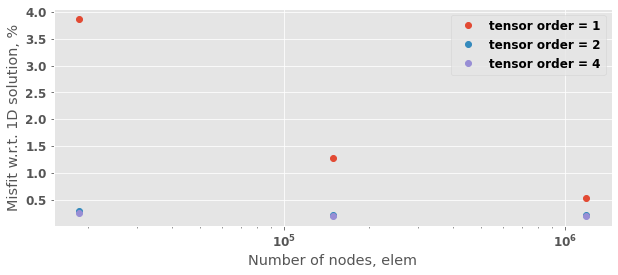

In [42]:
plt.figure(figsize = (10,4))



for nodes_per_el, to in zip([8,27,125], [1,2,4]):

    nnodes = []
    ynodes = []
    for key in comparison.keys():
        keydata = np.array(key.split('_'), dtype=int)
        if keydata[1] == nodes_per_el:
            nnodes.append(keydata[0])
            ynodes.append(comparison[key])
   
    print(nnodes)
    plt.semilogx(nnodes, np.abs(ynodes), 'o', label=f"tensor order = {to}")

#plt.loglog(nnodes, np.abs(ynodes), 'o', label="tensor order = 7")

plt.legend()

plt.ylabel("Misfit w.r.t. 1D solution, %")
plt.xlabel("Number of nodes, elem")

plt.savefig("convergence_plot.pdf")

In [51]:
x = [1,2,4] 
y = [18575, 148600, 1188800]
xx, yy = np.meshgrid([8,27,125], [18575, 148600, 1188800])

In [58]:
error = np.zeros_like(xx, dtype=float)
for i in range(3):
    for j in range(3):
        error[i,j] = comparison[f'{yy[i,j]}_{xx[i,j]}']

In [59]:
error

array([[-3.87665403, -0.29481709, -0.25640827],
       [-1.28424856, -0.2054172 , -0.1888014 ],
       [-0.52822264, -0.20919721, -0.19927006]])

In [80]:
xx

array([[  8,  27, 125],
       [  8,  27, 125],
       [  8,  27, 125]])

In [81]:
yy

array([[  18575,   18575,   18575],
       [ 148600,  148600,  148600],
       [1188800, 1188800, 1188800]])

In [82]:
x = [1,2,4] 
y = [18575, 148600, 1188800]

In [105]:
np.log10(np.abs(error))

array([[ 0.58845704, -0.53044735, -0.59106798],
       [ 0.10864909, -0.6873632 , -0.72399479],
       [-0.27718299, -0.67944412, -0.70055795]])

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # Remove the CWD from sys.path while we load stuff.


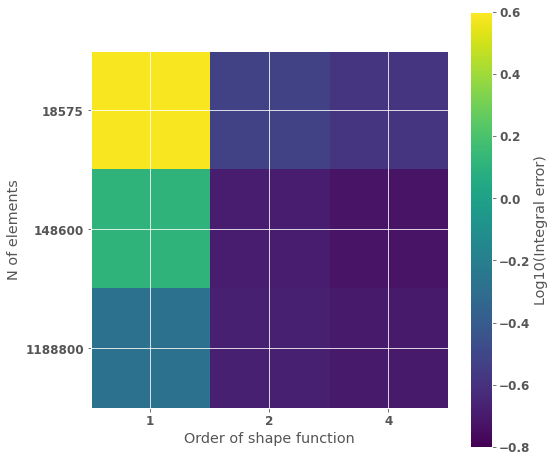

In [116]:
from matplotlib import colors
from matplotlib import pyplot as plt, cm
plt.figure(figsize=(8,8))
plt.imshow(np.log10(np.abs(error)))
plt.grid(True)
plt.xticks([0, 1, 2], labels=x)
plt.yticks([0, 1, 2], labels=y)
plt.xlabel("Order of shape function")
plt.ylabel("N of elements")
plt.colorbar(ticks = [-0.8,-0.6, -0.4,-0.2, 0.0, 0.2, 0.4, 0.6], label="Log10(Integral error)")
plt.clim(-0.8, 0.6)

In [ ]:
plt

In [46]:
comp_backup = comparison.copy()

In [47]:
comparison

{'148600_8': -1.284248564039443,
 '1188800_8': -0.52822263970755934,
 '18575_8': -3.8766540265606624,
 '18575_125': -0.2564082660071243,
 '148600_125': -0.18880140071590182,
 '1188800_125': -0.19927006125363658,
 '18575_27': -0.29481708786709621,
 '148600_27': -0.20541719567555458,
 '1188800_27': -0.20919720703893491}